## DATA 620 Project 1

**Team 2:** Pavan Akula, Nathan (Seoungyoon) Lim, Christophe Hunt, Joel Park, Ilya Kats

<img src="https://raw.githubusercontent.com/ilyakats/CUNY-DATA620/master/Team-Final/Project1/capitol-logo.png" width="300" height="95" />

### Project Description

The goal of the project is to create and analyze a social network for cosponsorship relationships within the U.S. Senate. Any mention of *bills* below implies *bills and resolutions*. Bills can be introduced by several members, but only one, whose name appears first on the bill, is considered its sponsor. All others are cosponsors. Cosponsors can be added to the bill at the time of the introduction or at a later date. There is no limit to the number of cosponsors a bill can have; although, this was not always the case. Members may cosponsor bills for various reasons - because they support it, because they want to have a record of supporting it, because their constituents request it, and even to show support for bill's sponsor. As such the cosponsorship links may demonstrate associations and relationships between members. Of course, there are many other types of associations that factor into a political relationship, but cosponsorship may provide unique perspective.

Please note that bills have many characteristics. Some are more important or more controversial than others. Bills also have different statuses - anything from Introduced to Signed or Vetoed by the President. This analysis does not differentiate between different types of bills.

Specific project requirements:
- Identify and load a network dataset that has some categorical information available for each node.
- For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
- Compare your centrality measures across your categorical groups.

### Data Source

For the project, we are analyzing cosponsorship relationships within the Senate of the 114th Congress that met from January 3, 2015 to January 3, 2017. The official repository of the U.S. legislative data is [Congress.gov](https://www.congress.gov/). The bills data is also maintained by the U.S. Government Publishing Office. The data for the 114th Congress is available at [https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/]. The data is stored in XML format and contains significant amount of metadata to describe a bill and its activity in Congress.

The public [@unitedstates](https://theunitedstates.io/) project maintains data and tools to access and analyze the governmental data including congressional data. Our **primary data source** is archived bills data from the 114th Congress prepared by the [Sunlight Foundation](https://sunlightfoundation.com/). The data is saved in JSON format. Data access and format description is available at [https://github.com/unitedstates/congress/wiki].

Party affiliation was extracted from Congress.gov. [https://www.congress.gov/help/field-values/member-bioguide-ids]

Ideology score was extracted from report card prepared by [GovTrack.us](https://www.govtrack.us/congress/members/report-cards/2016/senate/ideology).

### Data Import

Import data from Google Cloud SQL database.

In [ ]:
# Load libraries
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import networkx as nx
import operator

In [28]:
# Retrieve data from the database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, 
                          user='root', passwd='data620pw',
                          db='billsdata')

members = pd.read_sql('SELECT name, party, ideology_score FROM members;', con=sql_con)
sponsorships = pd.read_sql('SELECT cs.name AS Source, s.name AS Target, COUNT(*) AS EdgeNo '
                           'FROM sponsors AS s INNER JOIN cosponsors AS cs '
                           'ON s.billID = cs.billID '
                           'GROUP BY Source, Target;', con=sql_con)

sql_con.close()

List of senators including party affiliations and ideology score. For ideology score 0 represents liberal and 1 conservative.

In [130]:
print members.sort_values('ideology_score')

                     name        party  ideology_score
28       Elizabeth Warren   Democratic        0.000000
7         Bernard Sanders  Independent        0.039823
27       Edward J. Markey   Democratic        0.040362
0              Al Franken   Democratic        0.051538
53  Kirsten E. Gillibrand   Democratic        0.063093
78         Richard Durbin   Democratic        0.073587
38           Jeff Merkley   Democratic        0.079128
4           Barbara Boxer   Democratic        0.106301
75     Richard Blumenthal   Democratic        0.110664
32              Jack Reed   Democratic        0.113209
88          Sherrod Brown   Democratic        0.116969
86     Sheldon Whitehouse   Democratic        0.122531
62        Mazie K. Hirono   Democratic        0.127639
26       Dianne Feinstein   Democratic        0.136649
91          Tammy Baldwin   Democratic        0.137085
3     Barbara A. Mikulski   Democratic        0.151526
73           Patty Murray   Democratic        0.153076
12     Cha

Initiliaze directed graph and import nodes and edges. A node represents a senator. A directed edge represents a cosponsorship of a legislation of the target node (senator) by source node (senator). Each node contains 3 attributes - party affiliation, ideology score and color. All edges are weighted. The weight of an edge is nubmer of cosponsorships between two nodes.

In [120]:
# Function to convert party affiliation to color
def party_color(p):
    if p == 'Democratic':
        return 'blue'
    elif p == 'Republican':
        return 'red'
    else:
        return 'white'

# Initialize graph
G = nx.DiGraph()

# Add nodes with attributes
for index, row in members.iterrows():
    G.add_node(row['name'], 
               party=row['party'], 
               ideology=row['ideology_score'],
               color=party_color(row['party']))

# Add edges with weights
# Weight is equal to number of cosponsorships between nodes
for index, row in sponsorships.iterrows():
    G.add_edge(row['Source'], row['Target'], weight = row['EdgeNo'])

In [125]:
# Prepare 3 lists containing nodes for Democractic, Republican and Independent Senators
Dem = []
Rep = []
Ind = []
for i,j in G.nodes_iter(data=True):
    if j['party'] == 'Democratic':
        Dem.append(i)
    elif j['party'] == 'Republican':
        Rep.append(i)
    elif j['party'] == 'Independent':
        Ind.append(i)

Consider two independent senators Sen. King, Jr. and Sen. Sanders.

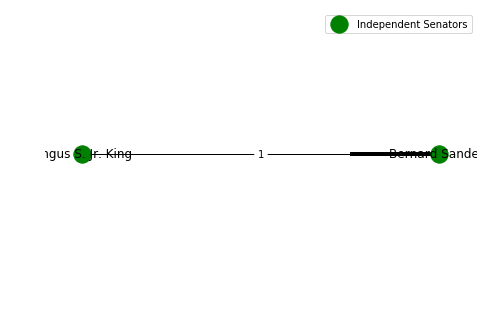

In [129]:
IG = G.subgraph(Ind)
nx.draw_circular(IG, with_labels = True, node_color='green')
edge_labels = nx.get_edge_attributes(IG,'weight')
nx.draw_networkx_edge_labels(IG, pos=nx.circular_layout(IG), edge_labels = edge_labels)
plt.legend(["Independent Senators"])
plt.show()

Sen. King, Jr. cosponsored a bill sponsored by Sen. Sanders. The weight of the edge is 1, so Sen. King, Jr. cosponsored only one of Sen. Sanders' bills.

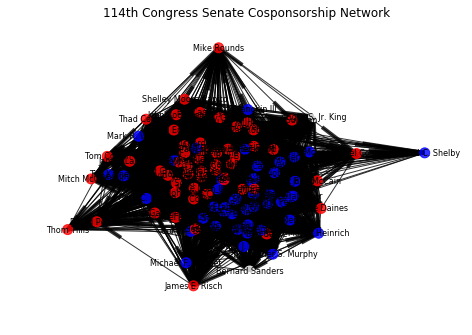

In [133]:
# Draw graph
colormap = []
for n in G.nodes():
    colormap.append(G.node[n]['color'])
pos = nx.spring_layout(G, k=0.3, iterations=10)
nx.draw(G, with_labels=True, pos=pos, 
        node_color=colormap, 
        node_size=100, font_size=8, alpha=0.8)
plt.title('114th Congress Senate Cosponsorship Network')
plt.show()

### Basic Summary Statistics

There were 3,275 bills introduced in the Senate during the 114th Congress. Number of cosponsors ranged from 0 to 74 (Bill S. 527: *A bill to award a Congressional Gold Medal to the Foot Soldiers who participated in Bloody Sunday, Turnaround Tuesday, or in the final Selma to Montgomery Voting Rights March in March of 1965, which served as a catalyst for the Voting Rights Act of 1965.*). Average number of cosponsors per bill is 5.27.

In [6]:
nx.number_of_nodes(G)

100

In [137]:
G.size()

6200

In [136]:
G.size(weight='weight')

17274.0

In [8]:
nx.diameter(G)

3

In [9]:
nx.average_shortest_path_length(G)

1.373939393939394

The network contains 100 nodes with 6,200 edges representing 17,274 co-sponsorship relationships in the Senate of 114th Congress. The diameter of the network is 3 with the average shortest path 1.37.

### Degrees

Since this is a directed network each node has an in-degree and an out-degree. An **in-degree value** is a number of co-sponsors each senator has for his or her bills. An **out-degree** value is a number of bills a senator co-sponsored. Please note that number of bills sponsored by a senator is not stored or analyzed in this network.

#### Top 10 Highest Out-Degree Nodes

In [138]:
o = G.out_degree(weight='weight')
s = sorted(o.items(), key=operator.itemgetter(1), reverse=True)[0:10]
print '%-25s %-13s %-3s' % ('Senator', 'Party', 'Out-Degrees')
print '%-25s %-13s %-3s' % ('-------', '-----', '-----------')
for n, c in s:
    print '%-25s %-13s %-3s' % (n, G.node[n]['party'], c)

Senator                   Party         Out-Degrees
-------                   -----         -----------
Kirsten E. Gillibrand     Democratic    341
Richard Blumenthal        Democratic    341
Al Franken                Democratic    324
Kelly Ayotte              Republican    299
Tammy Baldwin             Democratic    293
Amy Klobuchar             Democratic    286
Edward J. Markey          Democratic    281
Charles E. Schumer        Democratic    273
Christopher A. Coons      Democratic    271
Jeff Merkley              Democratic    270


Interestingly, it seems that democrats added their co-sponsorships to bills much more often than republicans. Let us look at subgraph of all nodes with at least 200 out-degrees.

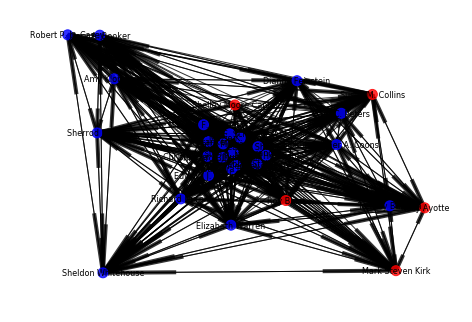

In [140]:
# Subgraph with nodes of at least 200 outgoing edges (weighted)
# Members cosponsoring a lot of other members
o = G.out_degree(weight='weight')
to_keep = [n for n in o if o[n]>=200]
SG=G.subgraph(to_keep)

colormap = []
for n in SG.nodes():
    colormap.append(SG.node[n]['color'])
pos = nx.spring_layout(SG, iterations=10)
nx.draw(SG, with_labels=True, pos=pos,
        node_color=colormap, 
        node_size=100, font_size=8, alpha=0.8)
plt.show()

#### Top 10 Highest In-Degree Nodes

In [141]:
i = G.in_degree(weight='weight')
s = sorted(i.items(), key=operator.itemgetter(1), reverse=True)[0:10]
print '%-25s %-13s %-3s' % ('Senator', 'Party', 'In-Degrees')
print '%-25s %-13s %-3s' % ('-------', '-----', '----------')
for n, c in s:
    print '%-25s %-13s %-3s' % (n, G.node[n]['party'], c)

Senator                   Party         In-Degrees
-------                   -----         ----------
Chuck Grassley            Republican    524
Benjamin L. Cardin        Democratic    430
Orrin G. Hatch            Republican    419
John Thune                Republican    398
Sherrod Brown             Democratic    380
Patty Murray              Democratic    376
Mark Steven Kirk          Republican    334
Ron Wyden                 Democratic    331
Jerry Moran               Republican    317
Kelly Ayotte              Republican    310


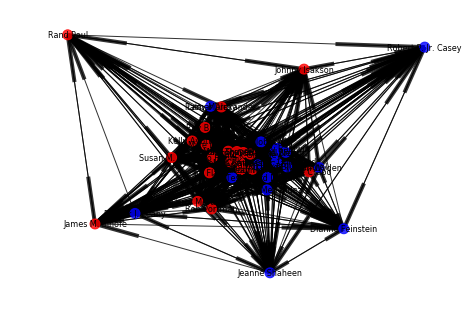

In [220]:
# Subgraph with nodes of at least 200 incoming edges (weighted)
# Members with a lot of cosponsors
i = G.in_degree(weight='weight')
to_keep = [n for n in o if i[n]>200]
SG=G.subgraph(to_keep)

colormap = []
for n in SG.nodes():
    colormap.append(SG.node[n]['color'])
pos = nx.spring_layout(SG, iterations=10)
nx.draw(SG, with_labels=True, pos=pos,
        node_color=colormap, 
        node_size=100, font_size=8, alpha=0.8)
plt.show()

In [142]:
# Average number of degrees in the network
num_neighbors = nx.degree(G, weight='weight')
avg = 0
for key in num_neighbors:
    avg = avg + num_neighbors[key]
print avg/float(len(num_neighbors))

345.48


Let us consider all co-sponsorships by 3 senators - Sen. King, Jr., an Independent from Maine with a centrist ideology score, Sen. Warren, a Democrat from Massachusetts and the most liberal member, and Sen. Imhofe, A Republican from Oklahoma and the most conservative member.

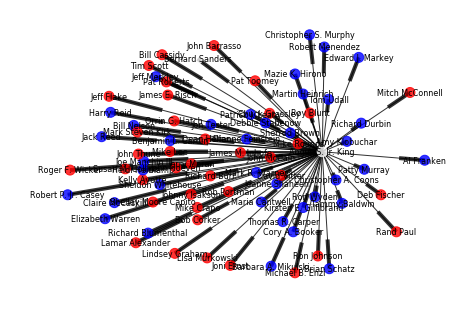

In [27]:
# All outgoing edges for Sen. King (independent)
SG = nx.ego_graph(G, 'Angus S. Jr. King', radius=1)
remove_edges = []
for e in SG.edges_iter():
    if e[0] != 'Angus S. Jr. King':
        remove_edges.append(e)
SG.remove_edges_from(remove_edges)

colormap = []
for n in SG.nodes():
    colormap.append(SG.node[n]['color'])
#pos = nx.spring_layout(SG, iterations=10)
nx.draw(SG, with_labels=True, 
        node_color=colormap, 
        node_size=100, font_size=8, alpha=0.8)
plt.show()

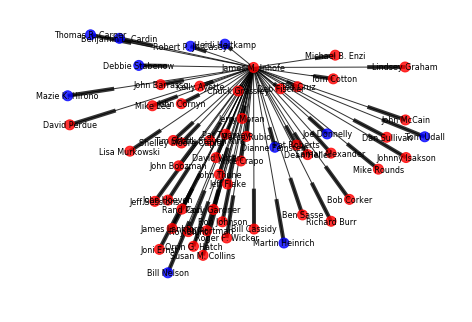

In [26]:
# All outgoing edges for Sen. Inhofe (most conservative)
SG = nx.ego_graph(G, 'James M. Inhofe', radius=1)
remove_edges = []
for e in SG.edges_iter():
    if e[0] != 'James M. Inhofe':
        remove_edges.append(e)
SG.remove_edges_from(remove_edges)

colormap = []
for n in SG.nodes():
    colormap.append(SG.node[n]['color'])
#pos = nx.spring_layout(SG, iterations=10)
nx.draw(SG, with_labels=True, 
        node_color=colormap, 
        node_size=100, font_size=8, alpha=0.8)
plt.show()

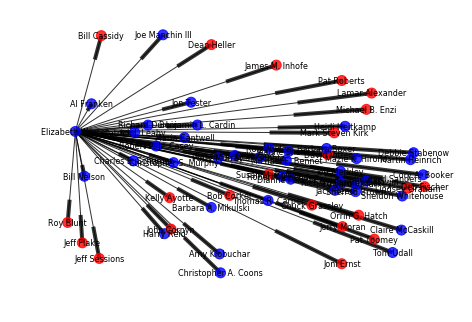

In [25]:
# All outgoing edges for Sen. Warren (most liberal)
SG = nx.ego_graph(G, 'Elizabeth Warren', radius=1)
remove_edges = []
for e in SG.edges_iter():
    if e[0] != 'Elizabeth Warren':
        remove_edges.append(e)
SG.remove_edges_from(remove_edges)

colormap = []
for n in SG.nodes():
    colormap.append(SG.node[n]['color'])
#pos = nx.spring_layout(SG, iterations=10)
nx.draw(SG, with_labels=True, 
        node_color=colormap, 
        node_size=100, font_size=8, alpha=0.8)
plt.show()

It seems that Sen. King's support is split fairly equally between bills introduced by Democrat or Republican Senators. Support of most extreme members seems to align closer to their ideology.

### Centralities

In [143]:
# Define function that would create a sorted list, from highest to lowest
# This function was taken from page 47 from "Social Network Analysis for Startups".

def sorted_map(map):
    ms = sorted(map.iteritems(), key=lambda (k,v): (-v,k)) 
    return ms

#### Top 10 Highest In-Degree Centralities

In [93]:
deg = nx.in_degree_centrality(G)
print '%-25s %-13s %-13s %-3s' % ('Senator', 'Party', 'In-Degrees', 'In-Degree Centrality')
print '%-25s %-13s %-13s %-3s' % ('-------', '-----', '----------', '--------------------')
for n in sorted_map(deg)[0:10]:
    print '%-25s %-13s %-13s %-3s' % (n[0], G.node[n[0]]['party'], G.degree(n[0]), round(n[1],4))

Senator                   Party         In-Degrees    In-Degree Centrality
-------                   -----         ----------    --------------------
Chuck Grassley            Republican    160           0.9697
Orrin G. Hatch            Republican    156           0.9697
Kelly Ayotte              Republican    182           0.9596
Jeff Flake                Republican    140           0.9293
Roy Blunt                 Republican    170           0.9192
John Thune                Republican    144           0.9091
Susan M. Collins          Republican    164           0.899
Jerry Moran               Republican    160           0.8889
Johnny Isakson            Republican    147           0.8889
Benjamin L. Cardin        Democratic    155           0.8788


#### Top 10 Highest Out-Degree Centralities

In [94]:
deg = nx.out_degree_centrality(G)
print '%-25s %-13s %-13s %-3s' % ('Senator', 'Party', 'Out-Degrees', 'Out-Degree Centrality')
print '%-25s %-13s %-13s %-3s' % ('-------', '-----', '-----------', '---------------------')
for n in sorted_map(deg)[0:10]:
    print '%-25s %-13s %-13s %-3s' % (n[0], G.node[n[0]]['party'], G.degree(n[0]), round(n[1],4))

Senator                   Party         Out-Degrees   Out-Degree Centrality
-------                   -----         -----------   ---------------------
Kelly Ayotte              Republican    182           0.8788
Jeanne Shaheen            Democratic    156           0.798
Mark Steven Kirk          Republican    166           0.798
Roy Blunt                 Republican    170           0.798
Kirsten E. Gillibrand     Democratic    152           0.7879
Angus S. Jr. King         Independent   109           0.7778
Christopher A. Coons      Democratic    135           0.7677
Gary C. Peters            Democratic    127           0.7677
Al Franken                Democratic    134           0.7576
Jon Tester                Democratic    149           0.7576


#### Top 10 Highest Closeness Centralities

In [73]:
close = nx.closeness_centrality(G)
print '%-25s %-13s %-3s' % ('Senator', 'Party', 'Closeness')
print '%-25s %-13s %-3s' % ('-------', '-----', '---------')
for n in sorted_map(close)[0:10]:
    print '%-25s %-13s %-3s' % (n[0], G.node[n[0]]['party'], round(n[1],4))

Senator                   Party         Closeness
-------                   -----         ---------
Kelly Ayotte              Republican    0.8919
Jeanne Shaheen            Democratic    0.8319
Mark Steven Kirk          Republican    0.8319
Roy Blunt                 Republican    0.8319
Kirsten E. Gillibrand     Democratic    0.825
Angus S. Jr. King         Independent   0.8182
Christopher A. Coons      Democratic    0.8115
Gary C. Peters            Democratic    0.8115
Al Franken                Democratic    0.8049
Jon Tester                Democratic    0.8049


In July 2013, Newsmax reported on the 25 most influential women of the GOP. "Leading off is Kelly Ayotte, the senator from New Hampshire who is an emerging force in Congress." [http://www.newsmax.com/politics/newsmax-top-25-women/2013/07/31/id/518085/]

#### Top 10 Highest Betweenness Centralities

In [74]:
between = nx.betweenness_centrality(G, weight='weight')
print '%-25s %-13s %-3s' % ('Senator', 'Party', 'Betweenness')
print '%-25s %-13s %-3s' % ('-------', '-----', '-----------')
for n in sorted_map(between)[0:10]:
    print '%-25s %-13s %-3s' % (n[0], G.node[n[0]]['party'], round(n[1],4))

Senator                   Party         Betweenness
-------                   -----         -----------
Tom Udall                 Democratic    0.0205
Claire McCaskill          Democratic    0.0205
Bob Corker                Republican    0.0199
Lindsey Graham            Republican    0.0184
Pat Toomey                Republican    0.0172
Heidi Heitkamp            Democratic    0.0164
John Hoeven               Republican    0.0153
Bill Cassidy              Republican    0.0153
Jeff Flake                Republican    0.0145
Thomas R. Carper          Democratic    0.0141


#### Top 10 Highest Eigenvector Centralities

In [75]:
eigen = nx.eigenvector_centrality(G, weight='weight')
print '%-25s %-13s %-3s' % ('Senator', 'Party', 'Eigenvector')
print '%-25s %-13s %-3s' % ('-------', '-----', '-----------')
for n in sorted_map(eigen)[0:10]:
    print '%-25s %-13s %-3s' % (n[0], G.node[n[0]]['party'], round(n[1],4))

Senator                   Party         Eigenvector
-------                   -----         -----------
Chuck Grassley            Republican    0.2612
Benjamin L. Cardin        Democratic    0.2195
Patty Murray              Democratic    0.206
Orrin G. Hatch            Republican    0.1959
Sherrod Brown             Democratic    0.1928
John Thune                Republican    0.1821
Ron Wyden                 Democratic    0.1677
Dianne Feinstein          Democratic    0.1657
Jeanne Shaheen            Democratic    0.1622
Mark Steven Kirk          Republican    0.1581


Sen. Grassley has been in the Senate since 1981. For multiple years, he was a member of the Senate Finance Committee, which is considered to be one of the most powerful committees in Congress. He is currently the chairman of the Judiciary Committee. As of July 2012, Sen. Grassley cast almost 11,000 votes and had only missed 35 votes in his Senate career.

### Analysis by Party Affiliation

#### Subgraphs by Party Affiliation

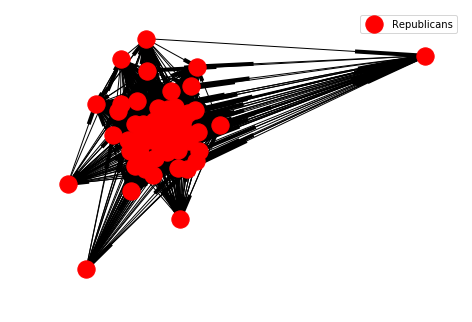

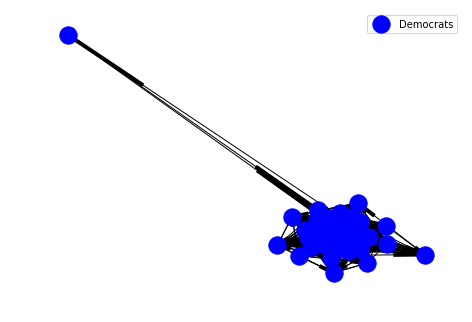

In [117]:
RG = G.subgraph(Rep)
nx.draw(RG, node_color='red')
plt.legend(["Republicans"])
plt.show()

DG = G.subgraph(Dem)
nx.draw(DG, node_color='blue')
plt.legend(["Democrats"])
plt.show()

#### Eigenvector Centrality for Republican Subgraph

In [104]:
eigen = nx.eigenvector_centrality(RG, weight='weight')
print '%-25s %-13s %-13s %-3s' % ('Senator', 'Party', 'Ideology', 'Eigenvector')
print '%-25s %-13s %-13s %-3s' % ('-------', '-----', '--------', '-----------')
for n in sorted_map(eigen)[0:10]:
    print '%-25s %-13s %-13s %-3s' % (n[0], RG.node[n[0]]['party'], RG.node[n[0]]['ideology'], round(n[1],4))

Senator                   Party         Ideology      Eigenvector
-------                   -----         --------      -----------
Orrin G. Hatch            Republican    0.784214      0.3112
John Thune                Republican    0.842206      0.2792
Chuck Grassley            Republican    0.754884      0.2778
John Cornyn               Republican    0.852798      0.2292
Mark Steven Kirk          Republican    0.627177      0.2225
Mike Lee                  Republican    0.879451      0.2067
Roy Blunt                 Republican    0.814047      0.1948
Jerry Moran               Republican    0.793764      0.1936
Marco Rubio               Republican    0.814469      0.1897
Rand Paul                 Republican    0.773154      0.1879


Please note that Sen. Cornyn appears high on the eigenvector centrality list for Republican subgraph, but he is not on the top of the eigenvector centrality list of entire network.

#### Eigenvector Centrality for Democrat Subgraph

In [102]:
eigen = nx.eigenvector_centrality(DG, weight='weight')
print '%-25s %-13s %-3s' % ('Senator', 'Party', 'Eigenvector')
print '%-25s %-13s %-3s' % ('-------', '-----', '-----------')
for n in sorted_map(eigen)[0:10]:
    print '%-25s %-13s %-3s' % (n[0], DG.node[n[0]]['party'], round(n[1],4))

Senator                   Party         Eigenvector
-------                   -----         -----------
Patty Murray              Democratic    0.3195
Sherrod Brown             Democratic    0.2768
Benjamin L. Cardin        Democratic    0.266
Ron Wyden                 Democratic    0.233
Richard Blumenthal        Democratic    0.2322
Dianne Feinstein          Democratic    0.2021
Jeanne Shaheen            Democratic    0.2013
Robert P. Jr. Casey       Democratic    0.1989
Robert Menendez           Democratic    0.196
Kirsten E. Gillibrand     Democratic    0.1933


Looking at eigenvector centrality for party subgraphs, we see similar names, but the order is different. It implies that some party leaders are more willing than others to cross party lines.

#### In-Degree Centrality for Republican Subgraph

In [109]:
deg = nx.in_degree_centrality(RG)
print '%-25s %-13s %-13s %-3s' % ('Senator', 'Party', 'In-Degrees', 'In-Degree Centrality')
print '%-25s %-13s %-13s %-3s' % ('-------', '-----', '----------', '--------------------')
for n in sorted_map(deg):
    print '%-25s %-13s %-13s %-3s' % (n[0], RG.node[n[0]]['party'], RG.degree(n[0]), round(n[1],4))

Senator                   Party         In-Degrees    In-Degree Centrality
-------                   -----         ----------    --------------------
John Hoeven               Republican    88            1.0
Orrin G. Hatch            Republican    91            1.0
James M. Inhofe           Republican    97            0.9808
John Thune                Republican    93            0.9808
Ted Cruz                  Republican    86            0.9808
Chuck Grassley            Republican    89            0.9615
John Barrasso             Republican    93            0.9615
Kelly Ayotte              Republican    99            0.9615
Lamar Alexander           Republican    84            0.9615
Mike Lee                  Republican    82            0.9615
Rand Paul                 Republican    87            0.9615
Bob Corker                Republican    74            0.9423
Jerry Moran               Republican    94            0.9423
John Cornyn               Republican    94            0.9423
Ma

#### In-Degree Centrality for Democrat Subgraph

In [108]:
deg = nx.in_degree_centrality(DG)
print '%-25s %-13s %-13s %-3s' % ('Senator', 'Party', 'In-Degrees', 'In-Degree Centrality')
print '%-25s %-13s %-13s %-3s' % ('-------', '-----', '----------', '--------------------')
for n in sorted_map(deg):
    print '%-25s %-13s %-13s %-3s' % (n[0], DG.node[n[0]]['party'], DG.degree(n[0]), round(n[1],4))

Senator                   Party         In-Degrees    In-Degree Centrality
-------                   -----         ----------    --------------------
Kirsten E. Gillibrand     Democratic    86            1.0
Barbara A. Mikulski       Democratic    80            0.9773
Benjamin L. Cardin        Democratic    80            0.9773
Debbie Stabenow           Democratic    80            0.9773
Dianne Feinstein          Democratic    81            0.9773
Heidi Heitkamp            Democratic    76            0.9773
Jon Tester                Democratic    82            0.9773
Mazie K. Hirono           Democratic    83            0.9773
Ron Wyden                 Democratic    80            0.9773
Sherrod Brown             Democratic    81            0.9773
Bill Nelson               Democratic    73            0.9545
Jeanne Shaheen            Democratic    84            0.9545
Patrick J. Leahy          Democratic    81            0.9545
Richard Blumenthal        Democratic    81            0.9545

An interesting entry is the last one - Sen. Shelby. His in-degree centrality is unusually low. Further research shows that Sen. Shelby was a registered Democrat from 1987 to 1995. In 1995 he switched parties and has been a Republican ever since. His official bio lists both parties, but the list of congressmen on Congress.gov only lists his initial affiliation. Clearly and understandibly, Sen. Shelby does not enjoy a lot of support among Democrats nowadays.